In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

8692
8868


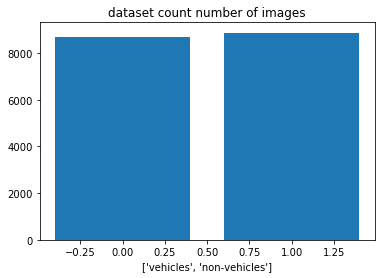

In [2]:
# import dataset
vehicles = glob.glob('data/vehicles/**/*.png')
non_vehicles = glob.glob('data/non-vehicles/**/*.png')

# show dataset stats distribution
num_vehicles = len(vehicles)
num_nonvehicles = len(non_vehicles)
plt.bar(np.arange(2), [num_vehicles, num_nonvehicles])
print(num_vehicles)
print(num_nonvehicles)
plt.xlabel( ["vehicles", "non-vehicles"])
plt.title('dataset count number of images')
#Note that there are about the same number of images in each category

In [15]:
#Move some images to the testdata folder for a validation set
import os
testdir = 'testdata'
category = 'vehicles'
veh_folder = os.path.join(testdir, category)
non_vehicles_folder = os.path.join(testdir, 'non-vehicles')
if not os.path.exists(veh_folder):
    os.mkdir(veh_folder)
if not os.path.exists(non_vehicles_folder):
    os.mkdir(non_vehicles_folder)
    
for i in range(100):
    fname = vehicles[i]
    filebasename = os.path.basename(fname)
    os.rename( fname, os.path.join(veh_folder, filebasename))
    
    fname = non_vehicles[i]
    filebasename = os.path.basename(fname)
    os.rename(fname, os.path.join(non_vehicles_folder, filebasename))

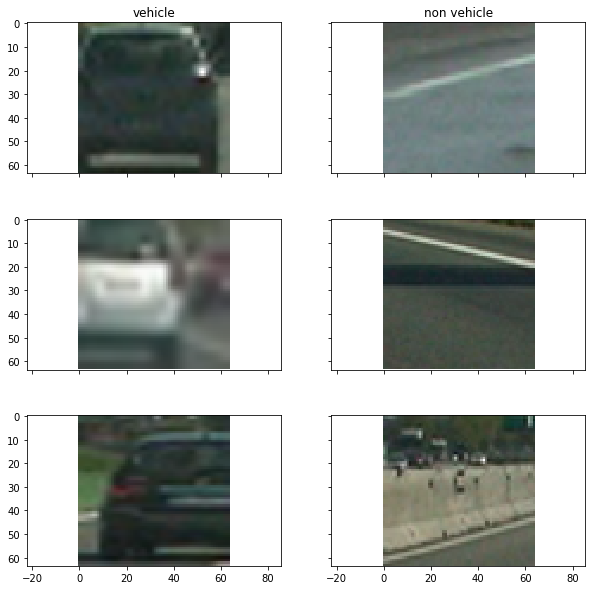

In [3]:
#visualize data

fig, axs = plt.subplots(3, 2, figsize = (10, 10), sharex = True, sharey = True)
for row, n in enumerate(np.random.randint(0, 1000, 3)):
    vehicle_img = mpimg.imread(vehicles[n])
    non_vehicle_img = mpimg.imread(non_vehicles[n])
    axs[row, 0].imshow(vehicle_img)
    axs[row, 1].imshow(non_vehicle_img)
fig.subplots_adjust(hspace = 0.3)
axs[0,0].set_title('vehicle')
axs[0,1].set_title('non vehicle')

In [4]:
# setup deep learning class activation map network to classify images. 
# we will make this a fully convolutional network
import keras
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.layers import Dropout, Reshape, Lambda, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

def build_model(input_shape = (64, 64, 3), is_training = True):
        model = Sequential()
        model.add(Lambda( lambda x : x / 127.5 - 1., input_shape= input_shape))
        model.add(Conv2D(64, (5, 5), activation="relu", padding = "same"))
        model.add(AveragePooling2D(pool_size = (2,2)))

        model.add(Conv2D(128, (3, 3), padding = "same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling2D(pool_size = (2,2))) 
    
        model.add(Conv2D(128, (3, 3), padding = "same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling2D(pool_size = (2,2)))     
    
        #this layer acts like a dense layer with 128 units but we keep it fully convolutional
        model.add(Conv2D(128, (8,8), activation = "relu", name = "dense1"))
        model.add(Dropout(0.6))   
    
        model.add(Conv2D(2, (1,1), name = "cam_fc"))
        model.add(Activation(K.softmax))
    
        if is_training:
            model.add(Reshape( (2,) ))
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
        return model

model = build_model()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 128)       0         
__________

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='checkpoints/weights.hdf5', verbose=1)

batch_size = 256
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'data',
        target_size=(64, 64),
        batch_size=batch_size)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        'testdata',
        target_size=(64, 64),
        batch_size=batch_size)

model.fit_generator(
        train_generator,
        steps_per_epoch= ( num_vehicles + num_nonvehicles) // batch_size,
        epochs= 20,
        validation_data = test_generator,
        validation_steps = 1,
        callbacks = [checkpointer])



In [22]:
model.save_weights("camfc.h5")

In [5]:
#build a heatmap with cnn
from scipy.misc import imresize
def gen_heatmap(model, img, class_index):
     img_crop = np.expand_dims( img[400:660, :, :], axis = 0)
     heatmap = model.predict(img_crop)
     heatmap[ heatmap < 0.99 ] = 0
     heatmap[ heatmap >= 0.99] = 1
     heatmap2 = np.squeeze(heatmap)[:, :, 1]
     return heatmap2

In [6]:
model = build_model(input_shape = (260, 1280, 3), is_training = False)
model.load_weights("camfc.h5")

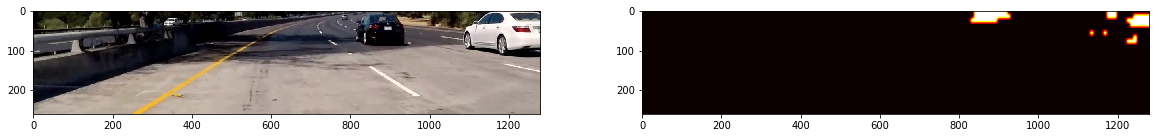

In [7]:
img = mpimg.imread("test_images/test5.jpg")
heatmap = gen_heatmap(model, img, 0)
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1, 2, 1)
plt.imshow(img[400:660])
fig.add_subplot(1, 2, 2)
plt.imshow(imresize(heatmap, (260, 1280)) , cmap = 'hot')
#fig.add_subplot(1, 2, 2)
#plt.imshow(img)

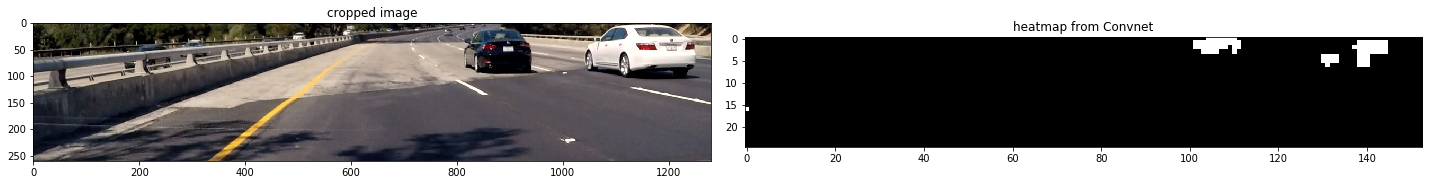

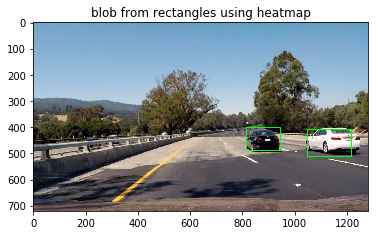

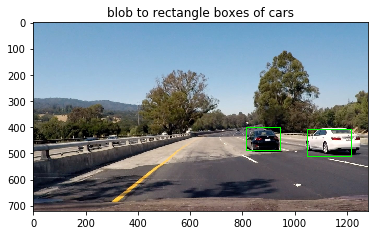

In [12]:
#get bounding boxes from the heatmap
import cv2

def get_bboxes(heatmap):
     xx, yy = np.meshgrid(np.arange(heatmap.shape[1]),np.arange(heatmap.shape[0]))
     x = (xx[heatmap == 1])
     y = (yy[heatmap == 1])
     boxpts = []
     for i,j in zip(x,y):
        topleft = [i*8, j*8 + 400]
        topright = [i*8 + 64, j*8 + 400]
        botright = [i*8 + 64, j*8 + 464]
        botleft = [i*8, j*8 + 464]
        boxpts.append( np.array([topleft, topright, botright, botleft])  )  
     return boxpts

def draw_voting_boxes(img, bboxes, minvotesforbox = 3):
    #generate filled rectangles from box and use it to vote on regions that could contain the car
    im2 = np.zeros(img.shape[0:2], dtype = np.uint8)
    for box in bboxes:
        mask = np.zeros(img.shape[0:2], dtype = np.uint8)
        im2 += cv2.fillPoly(mask, [box], (1,))
    im2 [ im2 < minvotesforbox ] = 0  
    return im2

#create a binary mask and get bounding rectangles from blobs
def drawcarboxes(img, bboxes):
    mask = np.zeros(img.shape[0:2], dtype = np.uint8)
    mask = draw_voting_boxes(mask, bboxes, 3)

    # find contours
    _, cnt, _ = cv2.findContours(mask, cv2.RETR_TREE,
                cv2.CHAIN_APPROX_SIMPLE)
    labeledimg = img.copy()
    
    car_boxes  = []
    for c in cnt:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(labeledimg,(x,y),(x+w,y+h),(0,255,0),2)
        car_boxes.append( (x,y,w,h) )
    return labeledimg, car_boxes

#draw boxes from heatmap on image
img = mpimg.imread("test_images/test4.jpg")
heatmap = gen_heatmap(model, img, 0)
bboxes = get_bboxes(heatmap)
im2, _ = drawcarboxes(img, bboxes)

# show plots
f = plt.figure(figsize = (20, 10))
ax1 = f.add_subplot(1, 2, 1)
ax1.imshow(img[400:660])
ax1.set_title('cropped image')
ax2 = f.add_subplot(1, 2, 2)
ax2.imshow(heatmap, cmap = 'gray')
ax2.set_title('heatmap from Convnet')
f.tight_layout()


plt.figure()
plt.imshow(im2)
plt.title('blob from rectangles using heatmap')

labeledimg, _ = drawcarboxes(img, bboxes)
plt.figure()
plt.imshow(labeledimg)
plt.title('blob to rectangle boxes of cars')

In [ ]:
#Run on video
import os

def run_vehicle_det(videofile):
    cap = cv2.VideoCapture(videofile)

    width = int(cap.get(3))
    height = int(cap.get(4))

    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    outfilename = os.path.join("output", "out_" + os.path.basename(videofile))
    out = cv2.VideoWriter(outfilename, fourcc, 30.0, (width, height))

    #detector = VehicleDetector('camfc.h5', height = 260, width = 1280)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            heatmap = gen_heatmap(model, img, 0)
            bboxes = get_bboxes(heatmap)
            outframe, _ = drawcarboxes(img, bboxes)
            out.write(outframe)

            cv2.imshow('frame', outframe)

            if cv2.waitKey(1) & 0xFF == ord('c'):
                break
        else:
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

run_vehicle_det('project_video.mp4')